<a href="https://colab.research.google.com/github/naingwinkyaw/IT123-Project_ID4288602M_/blob/main/L8/timeseries_forecasting_using_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting using RNN

In this exercise, we want to train a model to forecast the number of passengers that will ride on the bus or rail on the next day. We will be using the ridership data from Chicago's Transit Authority for this exercise.

## Setup

Install required dependencies and to ensure Pytorch is >= 2.6.0.

In [31]:
%pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 59.8 MB/s eta 0:00:00


In [32]:
from packaging.version import Version
import torch

assert Version(torch.__version__) >= Version("2.6.0")

This chapter can be very slow without a hardware accelerator, so if we can find one, let's use it:

In [33]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():  # for MacOS
    device = "mps"
else:
    device = "cpu"

In [34]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Dataset

Let's download the ridership dataset. The dataset consists of ridership data (both bus and rail) from Jan 2001 to Nov 2021.  The data was originally from the [Chicago's Data Portal](https://homl.info/ridership).

In [35]:
from pathlib import Path
import pandas as pd
import zipfile
import urllib.request

def download_and_extract_ridership_data():
    zip_path = Path("datasets/ridership.zip")
    if not zip_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/nyp-sit/iti121-2025s2/raw/refs/heads/main/L8/data/ridership.zip"
        urllib.request.urlretrieve(url, zip_path)
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall("datasets")

download_and_extract_ridership_data()

Now let's clean up the data a bit. In this exercise, we will forecast on the rail ridership only, so we will drop the bus columns, and column such as total_rides.

In [36]:
import pandas as pd
from pathlib import Path

path = Path("datasets/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [37]:
len(df)

7639

In [38]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


The *day_type* column contains W for Weekdays, A for Saturdays, and U for Sundays or holidays.

For this exercise, we will only forecast the ridership for rail transport.  So we will drop the bus column for simplicity.

In [39]:
df = df.drop("bus", axis=1)

## Exploratory Data Analysis

Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

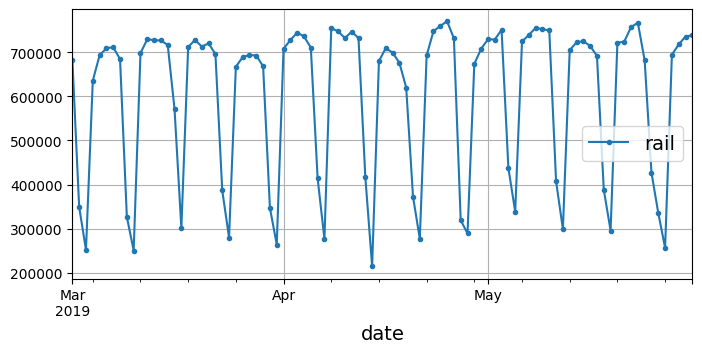

In [40]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

From the plot above, we can clearly see a similar pattern repeated every week. This is called a weekly seasonality. In fact, we can do a simple forecasting for tomorrow’s ridership by just copying the value from a week earlier, and this will probably yield reasonably good results. This is called naive forecasting: simply copying a past value to make our forecast.

We can use this naive forecasting to establish a baseline to compare against, when we use more sophisticated methods such as machine learning model to do the forecasting.

### Naive Forecasting

To visualize these naive forecasts, let’s overlay the original time series and the same time series lagged by one week (i.e., shifted toward the right) using dotted lines. We’ll also plot the difference between the two (i.e., the value at time t minus the value at time t – 7); this is called differencing.

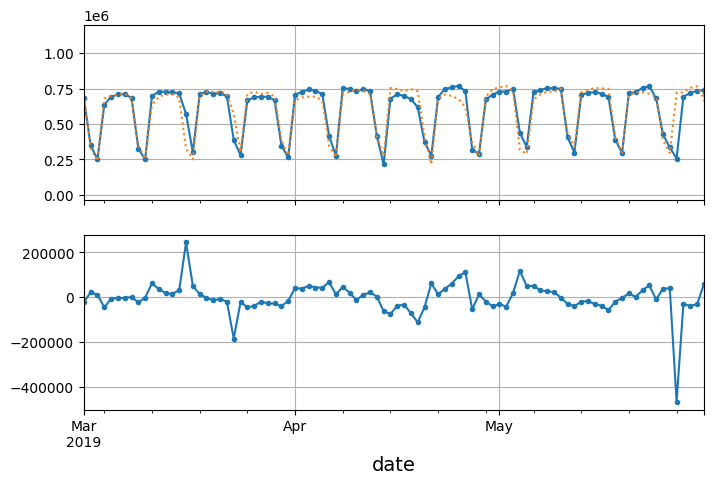

In [41]:
diff_7 = df["rail"].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series

plt.show()

We can see that the lagged time series track the actual time series quite closely. When a time series is correlated with a lagged version of itself, we say that the time series is autocorrelated. As you can see, most of the differences are fairly small, except at the end of May where there is a sudden dip in ridership.

this may be because of long weekend, which we can check out by looking at the day type.

In [42]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Indeed there is a public holiday on Monday. We could use this column to improve our forecasts, but for now let’s just measure the mean absolute error over the three-month period we’re arbitrarily focusing on—March, April, and May 2019—to get a rough idea:

In [43]:
diff_7.abs().mean()

np.float64(42143.27173913043)

Our naive forecast get a mean absolute error (MAE) of about 42,143 rail riders. It’s hard to tell at a glance how good or bad this is, so let’s put the forecast error into perspective by dividing them by the target value (Mean absolute percentage error or MAPE):

In [44]:
targets = df["rail"]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

np.float64(0.089947645033662)

We got about 9.0% MAPE for rail, which is actually not too bad.

### Longer-term seasonality

For time series data, it is also useful to examine if there is any longer term seasonality such as yearly seasonality. We can use differencing to remove trend and seasonality from a time series: it’s easier to study a stationary time series, meaning one whose statistical properties remain the same over time, without any seasonality or trends. Once you’re able to make accurate forecasts on the differenced time series, it’s easy to turn them into forecasts for the actual time series by just adding back the past values that were previously subtracted.

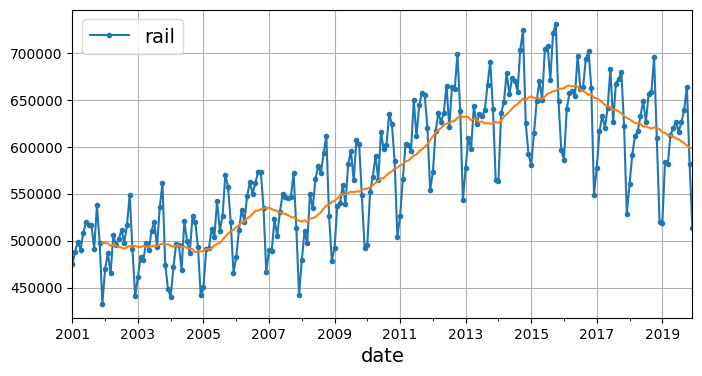

In [18]:
period = slice("2001", "2019")
df_monthly = df.select_dtypes(include="number").resample('ME').mean()
rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

Now we remove the yearly seasonality and take a look at the data. The trend is gone and the data looks more stationary.

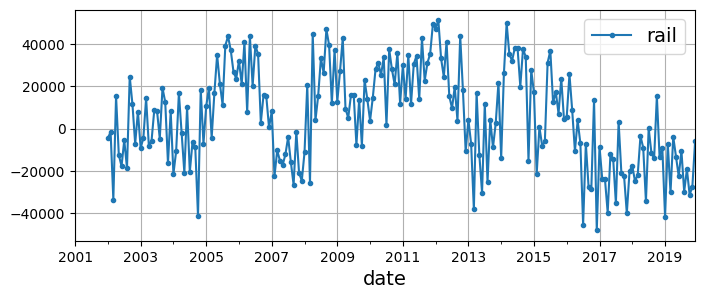

In [45]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

## Preparing the Data for Machine Learning Model

For this modelling exercise, we want to forecast tomorrow’s ridership based on the ridership of the past 8 weeks of data (56 days). The inputs to our model will therefore be sequences (usually a single sequence per day once the model is in production), each containing 56 values from time steps t – 55 to t. For each input sequence, the model will output a single value: the forecast for time step t + 1.

For training data, will use every 56-day window from the past as training data, and the target for each window will be the value immediately following it. To do that, we need to create a custom dataset that will chop a given time series into all possible windows of a given length, each with its corresponding target:

In [46]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, series, window_length):
        self.series = series
        self.window_length = window_length

    def __len__(self):
        return len(self.series) - self.window_length

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("dataset index out of range")
        end = idx + self.window_length  # 1st index after window
        window = self.series[idx : end]
        target = self.series[end]
        return window, target

Let's test if our TimeSeriesDataset is functioning correctly.

In [47]:
my_series = torch.tensor([[0], [1], [2], [3], [4], [5]])
my_dataset = TimeSeriesDataset(my_series, window_length=3)
for series, target in my_dataset:
    print("Series:", series, " Target:", target)

Series: tensor([[0],
        [1],
        [2]])  Target: tensor([3])
Series: tensor([[1],
        [2],
        [3]])  Target: tensor([4])
Series: tensor([[2],
        [3],
        [4]])  Target: tensor([5])


Now we can create a DataLoader for this tiny dataset, shuffling the windows and grouping them into batches of two:

In [48]:
from torch.utils.data import DataLoader
torch.manual_seed(0)
my_loader = DataLoader(my_dataset, batch_size=2, shuffle=True)
for i, (X, y) in enumerate(my_loader):
    print(f"batch {i}\nX:", X, " y:", y)

batch 0
X: tensor([[[0],
         [1],
         [2]],

        [[2],
         [3],
         [4]]])  y: tensor([[3],
        [5]])
batch 1
X: tensor([[[1],
         [2],
         [3]]])  y: tensor([[4]])


Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. When dealing with time series, you generally want to split across time.

We will convert the data to 32-bit float tensors, and scale them down by a factor of one million to ensure the values end up near the 0–1 range; this plays nicely with the default weight initialization and learning rate.

In [49]:
rail_train = torch.FloatTensor(df["rail"]["2016-01":"2018-12"].values / 1e6)
rail_valid = torch.FloatTensor(df["rail"]["2019-01":"2019-05"].values / 1e6)
rail_test = torch.FloatTensor(df["rail"]["2019-06":].values / 1e6)

The tensor produced is a 1D tensor, but for time series data, we need a 2D tensor of shape (time, feature). Let's add in additional dimension by using Pytorch `unsqueeze()` function.

In [50]:
rail_train.shape

torch.Size([1096])

In [26]:
rail_train = rail_train.unsqueeze(1)
rail_valid = rail_valid.unsqueeze(1)
rail_test = rail_test.unsqueeze(1)
print(rail_train.shape)

torch.Size([1096, 1])


Next, let’s use our TimeSeriesDataset class to create datasets for training, validation, and testing, and also create the corresponding data loaders. Since gradient descent expects the instances in the training set to be independent and identically distributed (IID), we must set shuffle to True - this will shuffle the windows, but not their contents:

In [27]:
window_length = 56
train_set = TimeSeriesDataset(rail_train, window_length)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_set = TimeSeriesDataset(rail_valid, window_length)
valid_loader = DataLoader(valid_set, batch_size=32)
test_set = TimeSeriesDataset(rail_test, window_length)
test_loader = DataLoader(test_set, batch_size=32)

In [28]:
for X, y in valid_loader:
    # print("X:", X)
    print(X.shape)
    print(y.shape)
    break

torch.Size([32, 56, 1])
torch.Size([32, 1])


Now we’re ready to build and train our forecasting model using RNN and LSTM.

## Training Sequence Model

Let's build some convenience methods first to evaluate and to train.  We choose Huber Loss as it is more robust to outliers and have smoother gradients for optimization.

In [51]:
import torch.nn as nn
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs, patience=10, factor=0.1):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=patience, factor=factor)
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        scheduler.step(val_metric)
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

def fit_and_evaluate(model, train_loader, valid_loader, lr, n_epochs=50,
                     patience=20, factor=0.1):
    loss_fn = nn.HuberLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.95)
    # metric = torchmetrics.MeanAbsoluteError().to(device)
    metric = torchmetrics.MeanAbsolutePercentageError().to(device)
    history = train(model, optimizer, loss_fn, metric,
                    train_loader, valid_loader, n_epochs=n_epochs,
                    patience=patience, factor=factor)
    # return min(history["valid_metrics"]) * 1e6
    return min(history["valid_metrics"]) * 100 # percentage

## Using a Simple RNN

In [52]:
class SimpleRnnModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs[:, -1])

In [53]:
torch.manual_seed(42)
model = SimpleRnnModel(input_size=1, hidden_size=32, output_size=1)
model = model.to(device)
fit_and_evaluate(model, train_loader, valid_loader, lr=0.05, n_epochs=50)

Epoch 1/50, train loss: 0.0487, train metric: 0.4789, valid metric: 0.3492
Epoch 2/50, train loss: 0.0181, train metric: 0.3367, valid metric: 0.3311
Epoch 3/50, train loss: 0.0137, train metric: 0.3074, valid metric: 0.3088
Epoch 4/50, train loss: 0.0122, train metric: 0.2814, valid metric: 0.2946
Epoch 5/50, train loss: 0.0115, train metric: 0.2628, valid metric: 0.2581
Epoch 6/50, train loss: 0.0105, train metric: 0.2478, valid metric: 0.2540
Epoch 7/50, train loss: 0.0090, train metric: 0.2241, valid metric: 0.2258
Epoch 8/50, train loss: 0.0064, train metric: 0.1722, valid metric: 0.1481
Epoch 9/50, train loss: 0.0055, train metric: 0.1538, valid metric: 0.1339
Epoch 10/50, train loss: 0.0048, train metric: 0.1415, valid metric: 0.1366
Epoch 11/50, train loss: 0.0044, train metric: 0.1356, valid metric: 0.1099
Epoch 12/50, train loss: 0.0043, train metric: 0.1345, valid metric: 0.1288
Epoch 13/50, train loss: 0.0043, train metric: 0.1326, valid metric: 0.1366
Epoch 14/50, train lo

6.913618743419647

## Deep RNNs

We can also stack multiple layers of RNN cells, just like CNN. In the code below, we add in additional `num_layers` argument so that we can instantiate multi-layer RNN.

![deep rnn](https://github.com/nyp-sit/iti121-2025s2/blob/main/L8/assets/deep_rnn.png?raw=true)

In [54]:
class DeepRnnModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers,
                          batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        # print(outputs.shape)
        # print(outputs[:, -1].shape)
        return self.output(outputs[:, -1])

In [56]:
torch.manual_seed(42)
model = DeepRnnModel(
    input_size=1, hidden_size=32, output_size=1, num_layers=3).to(device)
fit_and_evaluate(model, train_loader, valid_loader, lr=0.07, n_epochs=50)

Epoch 1/50, train loss: 0.0632, train metric: 0.5339, valid metric: 0.3725
Epoch 2/50, train loss: 0.0189, train metric: 0.3213, valid metric: 0.2460
Epoch 3/50, train loss: 0.0083, train metric: 0.1936, valid metric: 0.2572
Epoch 4/50, train loss: 0.0066, train metric: 0.1781, valid metric: 0.1204
Epoch 5/50, train loss: 0.0053, train metric: 0.1518, valid metric: 0.1412
Epoch 6/50, train loss: 0.0051, train metric: 0.1472, valid metric: 0.1566
Epoch 7/50, train loss: 0.0052, train metric: 0.1487, valid metric: 0.1039
Epoch 8/50, train loss: 0.0057, train metric: 0.1585, valid metric: 0.2011
Epoch 9/50, train loss: 0.0046, train metric: 0.1369, valid metric: 0.1452
Epoch 10/50, train loss: 0.0044, train metric: 0.1314, valid metric: 0.0967
Epoch 11/50, train loss: 0.0039, train metric: 0.1247, valid metric: 0.0871
Epoch 12/50, train loss: 0.0037, train metric: 0.1208, valid metric: 0.1278
Epoch 13/50, train loss: 0.0035, train metric: 0.1135, valid metric: 0.0990
Epoch 14/50, train lo

6.674753129482269

We can see some slight improvements in the forecast errors, measured by MAPE.

## Using LSTM

In [57]:
class LstmModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs[:, -1])

In [58]:
torch.manual_seed(42)
model = LstmModel(
    input_size=1, hidden_size=32, output_size=1, num_layers=1).to(device)
fit_and_evaluate(model, train_loader, valid_loader, lr=0.05, n_epochs=50)

Epoch 1/50, train loss: 0.0588, train metric: 0.5251, valid metric: 0.4384
Epoch 2/50, train loss: 0.0229, train metric: 0.3689, valid metric: 0.3618
Epoch 3/50, train loss: 0.0175, train metric: 0.3454, valid metric: 0.3572
Epoch 4/50, train loss: 0.0167, train metric: 0.3427, valid metric: 0.3587
Epoch 5/50, train loss: 0.0165, train metric: 0.3427, valid metric: 0.3543
Epoch 6/50, train loss: 0.0168, train metric: 0.3421, valid metric: 0.3540
Epoch 7/50, train loss: 0.0168, train metric: 0.3429, valid metric: 0.3572
Epoch 8/50, train loss: 0.0163, train metric: 0.3404, valid metric: 0.3596
Epoch 9/50, train loss: 0.0166, train metric: 0.3407, valid metric: 0.3569
Epoch 10/50, train loss: 0.0163, train metric: 0.3404, valid metric: 0.3541
Epoch 11/50, train loss: 0.0165, train metric: 0.3404, valid metric: 0.3533
Epoch 12/50, train loss: 0.0163, train metric: 0.3379, valid metric: 0.3539
Epoch 13/50, train loss: 0.0163, train metric: 0.3391, valid metric: 0.3597
Epoch 14/50, train lo

25.075843930244446

What do you observe about the performance of LSTM?

## Multivariate Prediction

So far, we have been looking at time series with only a single feature (i.e. the number of riders), or a univariate time series. Our models such as RNN/LTSTM can easily handle multivariate sequence data, without any need to change the codes.

Let's create a new dataset with multiple features now. We know from previous EDA, that public holiday or weekend affects the ridership. If we know that tomorrow is a public holiday, we can predict a lower ridership.

So let's create a new feature called `next_day_type` by shifting the day type series one day into the future.
We can do so easily with `shift(-1)` with the panda series.  We also one-hot-encode the `next_day_type` using `get_dummies()` function.

In [59]:
df_mulvar = df[['rail']]
df_mulvar["next_day_type"] = df["day_type"].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar, dtype=float)  # one-hot encode day type

In [60]:
df_mulvar.head()

,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,
2001-01-01,126455,0.0,0.0,1.0
2001-01-02,501952,0.0,0.0,1.0
2001-01-03,536432,0.0,0.0,1.0
2001-01-04,550011,0.0,0.0,1.0
2001-01-05,557917,1.0,0.0,0.0


We convert the data frame into torch tensors.

In [62]:
mulvar_train = torch.FloatTensor(df_mulvar["2016-01":"2018-12"].values / 1e6)
mulvar_valid = torch.FloatTensor(df_mulvar["2019-01":"2019-05"].values / 1e6)
mulvar_test = torch.FloatTensor(df_mulvar["2019-06":].values / 1e6)

If we used the TimeSeriesDataset as before, the targets would include the next day’s rail ridership, as well as the one-hot encoding of the following day type. We must tweak the TimeSeriesDataset to keep only the first value in the target, which is the rail ridership. One way to do this is to create a new MulvarTimeSeriesDataset class that extends the TimeSeriesDataset class and tweaks the __getitem__() method to filter the target:

In [63]:
class MulvarTimeSeriesDataset(TimeSeriesDataset):
    def __getitem__(self, idx):
        window, target = super().__getitem__(idx)
        return window, target[:1]

In [64]:
window_length = 56
mulvar_train_set = MulvarTimeSeriesDataset(mulvar_train, window_length)
mulvar_train_loader = DataLoader(mulvar_train_set, batch_size=32, shuffle=True)
mulvar_valid_set = MulvarTimeSeriesDataset(mulvar_valid, window_length)
mulvar_valid_loader = DataLoader(mulvar_valid_set, batch_size=32)
mulvar_test_set = MulvarTimeSeriesDataset(mulvar_test, window_length)
mulvar_test_loader = DataLoader(mulvar_test_set, batch_size=32)

Let's make sure the the X and y returned are of expected shape, before using them for training our model.

In [65]:
for X, y in mulvar_train_set:
    print(X.shape)
    print(y.shape)
    break

torch.Size([56, 4])
torch.Size([1])


In [66]:
print(y)

tensor([0.7500])


Let's try with our Deep RNN model, by changing the input_size to match the number of features, in this case 4.

In [ ]:
# torch.manual_seed(42)
model = DeepRnnModel(
    input_size=4, hidden_size=32, output_size=1, num_layers=3).to(device)
fit_and_evaluate(model, mulvar_train_loader, mulvar_valid_loader, lr=0.05, n_epochs=50)

## Forecasting Several Steps Ahead

So far we have only predicted the value at the next time step, but we could just as easily have predicted the value several steps ahead by changing the targets appropriately (e.g., to predict the ridership 2 weeks from now, we could just change the targets to be the value 14 days ahead instead of 1 day ahead). But what if we want to predict the next 14 values with a single model?

Now let's create an RNN that predicts the rail ridership for the next 14 days all at once, using the time series we built earlier. For this, we first need to prepare datasets appropriately.

We created a new dataset that inherits from the TimeSeriesDataset class and tweaks its `__len__()` and `__getitem__()` methods. The target is now a tensor containing the next 14 rail ridership values, rather than just the next value.

In [67]:
class ForecastAheadDataset(TimeSeriesDataset):
    def __len__(self):
        return len(self.series) - self.window_length - 14 + 1

    def __getitem__(self, idx):
        end = idx + self.window_length  # 1st index after window
        window = self.series[idx : end]
        target = self.series[end : end + 14, 0]  # 0 = rail ridership
        return window, target

In [68]:
window_length = 56
ahead_train_set = ForecastAheadDataset(mulvar_train, window_length)
ahead_train_loader = DataLoader(ahead_train_set, batch_size=32, shuffle=True)
ahead_valid_set = ForecastAheadDataset(mulvar_valid, window_length)
ahead_valid_loader = DataLoader(ahead_valid_set, batch_size=32)
ahead_test_set = ForecastAheadDataset(mulvar_test, window_length)
ahead_test_loader = DataLoader(ahead_test_set, batch_size=32)

In [69]:
for x, y in ahead_train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 56, 4])
torch.Size([32, 14])


In [70]:
print(x[0])

tensor([[3.3200e-01, 0.0000e+00, 0.0000e+00, 1.0000e-06],
        [7.6914e-01, 0.0000e+00, 0.0000e+00, 1.0000e-06],
        [7.9361e-01, 0.0000e+00, 0.0000e+00, 1.0000e-06],
        [7.9593e-01, 0.0000e+00, 0.0000e+00, 1.0000e-06],
        [8.0280e-01, 0.0000e+00, 0.0000e+00, 1.0000e-06],
        [7.7782e-01, 1.0000e-06, 0.0000e+00, 0.0000e+00],
        [4.3551e-01, 0.0000e+00, 1.0000e-06, 0.0000e+00],
        [3.1518e-01, 0.0000e+00, 0.0000e+00, 1.0000e-06],
        [7.6612e-01, 0.0000e+00, 0.0000e+00, 1.0000e-06],
        [7.8502e-01, 0.0000e+00, 0.0000e+00, 1.0000e-06],
        [7.7637e-01, 0.0000e+00, 0.0000e+00, 1.0000e-06],
        [7.9831e-01, 0.0000e+00, 0.0000e+00, 1.0000e-06],
        [7.5431e-01, 1.0000e-06, 0.0000e+00, 0.0000e+00],
        [4.2852e-01, 0.0000e+00, 1.0000e-06, 0.0000e+00],
        [2.9131e-01, 0.0000e+00, 0.0000e+00, 1.0000e-06],
        [7.7019e-01, 0.0000e+00, 0.0000e+00, 1.0000e-06],
        [7.6465e-01, 0.0000e+00, 0.0000e+00, 1.0000e-06],
        [7.831

We also need to change the output_size of our Lstm model to 14 instead of the original 1.

In [71]:
torch.manual_seed(42)
ahead_model = DeepRnnModel(input_size=4, hidden_size=32, output_size=14, num_layers=1)
ahead_model = ahead_model.to(device)
fit_and_evaluate(ahead_model, ahead_train_loader, ahead_valid_loader, lr=0.05, n_epochs=150)

Epoch 1/150, train loss: 0.0811, train metric: 0.5689, valid metric: 0.3822
Epoch 2/150, train loss: 0.0200, train metric: 0.3429, valid metric: 0.3525
Epoch 3/150, train loss: 0.0160, train metric: 0.3274, valid metric: 0.3437
Epoch 4/150, train loss: 0.0151, train metric: 0.3216, valid metric: 0.3346
Epoch 5/150, train loss: 0.0143, train metric: 0.3130, valid metric: 0.3234
Epoch 6/150, train loss: 0.0135, train metric: 0.3018, valid metric: 0.3055
Epoch 7/150, train loss: 0.0123, train metric: 0.2829, valid metric: 0.2718
Epoch 8/150, train loss: 0.0101, train metric: 0.2396, valid metric: 0.2199
Epoch 9/150, train loss: 0.0083, train metric: 0.2063, valid metric: 0.1980
Epoch 10/150, train loss: 0.0076, train metric: 0.1923, valid metric: 0.1951
Epoch 11/150, train loss: 0.0075, train metric: 0.1876, valid metric: 0.1942
Epoch 12/150, train loss: 0.0072, train metric: 0.1877, valid metric: 0.1861
Epoch 13/150, train loss: 0.0071, train metric: 0.1841, valid metric: 0.1995
Epoch 14

6.504830718040466

Now let's evaluate the model on one sample sequence from validation set.

In [72]:
ahead_model.eval()
with torch.no_grad():
    window = mulvar_valid[:window_length]  # shape [56, 4]
    X = window.unsqueeze(dim=0)      # shape [1, 56, 4]
    Y_pred = ahead_model(X.to(device))     # shape [1, 14]

In [73]:
print(window.shape)
print(X.shape)
print(Y_pred.shape)

torch.Size([56, 4])
torch.Size([1, 56, 4])
torch.Size([1, 14])


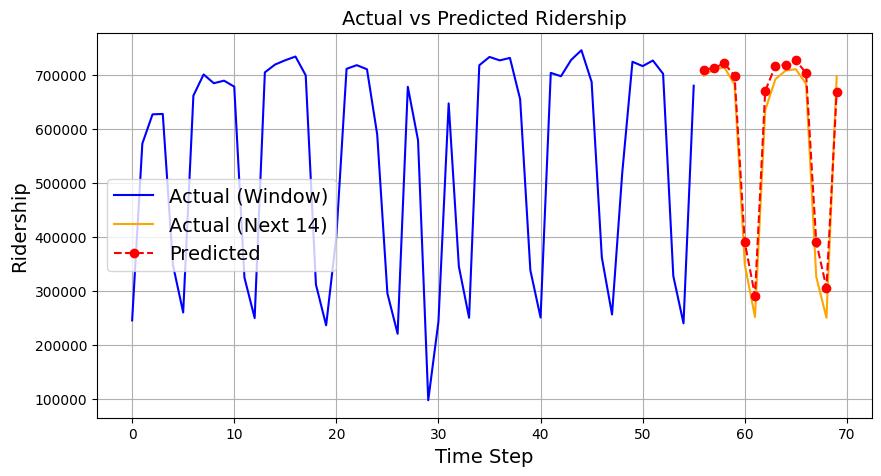

In [74]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# --- Parameters ---
window_size = X.shape[1]                      # e.g. 56
num_time_step_to_predict = Y_pred.shape[1]    # e.g. 14

# --- Prepare data ---
# Extract actual data (window + next steps)
actual_values = mulvar_valid[:window_size + num_time_step_to_predict, 0].cpu().numpy() * 1e6

# Extract predicted values (just the predicted part)
y_pred = Y_pred.cpu().numpy().flatten() * 1e6

# --- Plot ---
plt.figure(figsize=(10, 5))

# Plot full actual data (first 56 + next 14)
plt.plot(
    range(window_size),
    actual_values[:window_size],
    label='Actual (Window)',
    color='blue'
)

# Highlight the next 14 timesteps (actual future)
plt.plot(
    range(window_size, window_size + num_time_step_to_predict),
    actual_values[window_size:],
    label='Actual (Next 14)',
    color='orange'
)

# Overlay predictions
plt.plot(
    range(window_size, window_size + num_time_step_to_predict),
    y_pred,
    label='Predicted',
    color='red',
    linestyle='--',
    marker='o'
)

plt.xlabel('Time Step')
plt.ylabel('Ridership')
plt.title('Actual vs Predicted Ridership')
plt.legend()
plt.grid(True)
plt.show()
